# Part 1: Dashboard Basics

## Links
- **Live updated app:** https://data-to-descision-dashboard-nonewthing.streamlit.app
- **Repo:** https://github.com/TaoM29/data-to-descision-dashboard

## AI usage 
I used ChatGPT to help support and debug the Streamlit app (multipage layout, cached CSV loader, sidebar navigation, first-month table with LineChartColumn, and the Explorer page). I reviewed and adapted all suggested code before committing. I also used chatGPT to help me with the issue: st.page_link raised a KeyError on Cloud, so I switched to a robust sidebar radio approach that still fulfills the navigation requirement. 

## Work log 
I created a public GitHub repository and connected it to Streamlit Cloud. Locally, I set up a minimal Streamlit app (app.py) with a requirements.txt containing streamlit, pandas, and matplotlib, and deployed it to confirm the workflow. I added a Jupyter notebook (part-1.ipynb) as my development log.

For data, I used the supplied open-meteo-subset.csv. In the notebook I read it with Pandas, parsed the time column to datetime, and printed relevant summaries: head(), shape, dtypes, and missing-value counts. Then I plotted each numeric column separately against time (temperature, precipitation, wind speed, wind gusts, wind direction). To meet the “all columns together” requirement while handling different scales, I produced a normalized 0–1 chart so the series could share a single axis, noting that wind direction is circular and should be interpreted with care.

Next, I built the Streamlit app to mirror the notebook’s insights. I added a cached loader (@st.cache_data) in data_loader.py so the CSV is read once and reused. The app implements four pages accessible from a sidebar: Home (data preview), Data Table, Explorer, and About. The Data Table page constructs a row-wise summary (variable name, unit extracted from the column title, min/mean/max) and uses Streamlit’s LineChartColumn to display the first calendar month of values for each variable in a compact sparkline. The Explorer page provides a selectbox to choose a single column (or “All columns”) and a select_slider to pick a month range, defaulting to the first month. When “All columns” is selected, the app plots normalized series to keep a single y-axis; otherwise it plots the chosen variable with appropriate labeling and titles.

A few issues arose and were resolved: GitHub requires a personal access token for pushes (fixed by creating a PAT), and st.page_link raised a KeyError on Cloud, so I switched to a robust sidebar radio approach that still fulfills the navigation requirement. I verified that all notebook cells run end-to-end and that the deployed app matches the assignment specification. 


In [ ]:
from pathlib import Path
import pandas as pd

# Show more columns nicely
pd.set_option("display.max_columns", None)

# Path to CSV inside the repo
csv_path = Path("data") / "open-meteo-subset.csv"

# Read (auto-detect delimiter) and try parsing any date/time columns
df = pd.read_csv(csv_path, sep=None, engine="python")

for c in df.columns:
    if any(k in c.lower() for k in ["date", "time", "timestamp"]):
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce")
        except Exception:
            pass

# Relevant prints
display(df.head())                    # first rows
print("Shape:", df.shape)             # (rows, cols)
print("\nDtypes:\n", df.dtypes)       # data types
print("\nMissing values per column:\n", df.isna().sum())


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2020-01-01 00:00:00,-2.2,0.1,9.6,21.3,284
1,2020-01-01 01:00:00,-2.2,0.0,10.6,23.0,282
2,2020-01-01 02:00:00,-2.3,0.0,11.0,23.5,284
3,2020-01-01 03:00:00,-2.3,0.0,10.6,23.3,284
4,2020-01-01 04:00:00,-2.7,0.0,10.6,22.8,284


Shape: (8760, 6)

Dtypes:
 time                      datetime64[ns]
temperature_2m (°C)              float64
precipitation (mm)               float64
wind_speed_10m (m/s)             float64
wind_gusts_10m (m/s)             float64
wind_direction_10m (°)             int64
dtype: object

Missing values per column:
 time                      0
temperature_2m (°C)       0
precipitation (mm)        0
wind_speed_10m (m/s)      0
wind_gusts_10m (m/s)      0
wind_direction_10m (°)    0
dtype: int64


Numeric columns: ['temperature_2m (°C)', 'precipitation (mm)', 'wind_speed_10m (m/s)', 'wind_gusts_10m (m/s)', 'wind_direction_10m (°)']


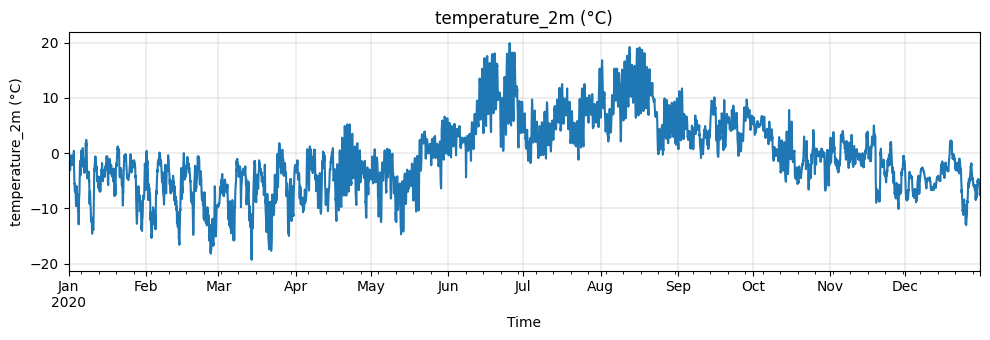

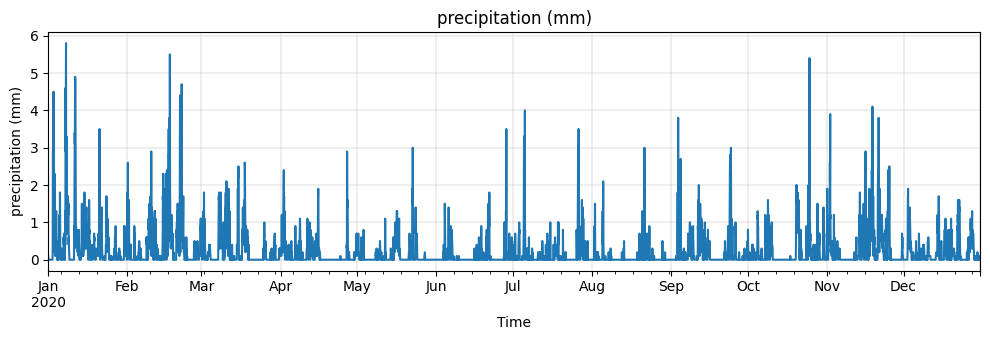

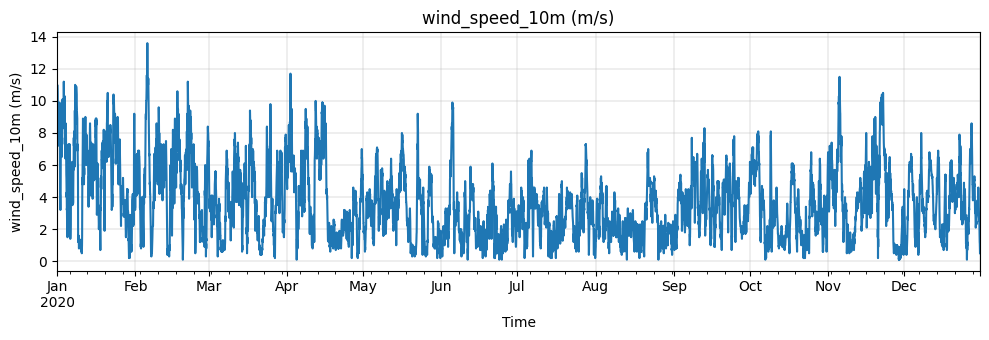

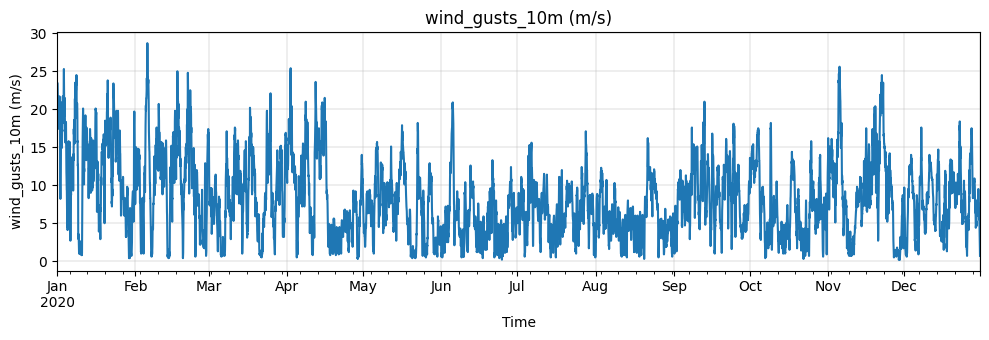

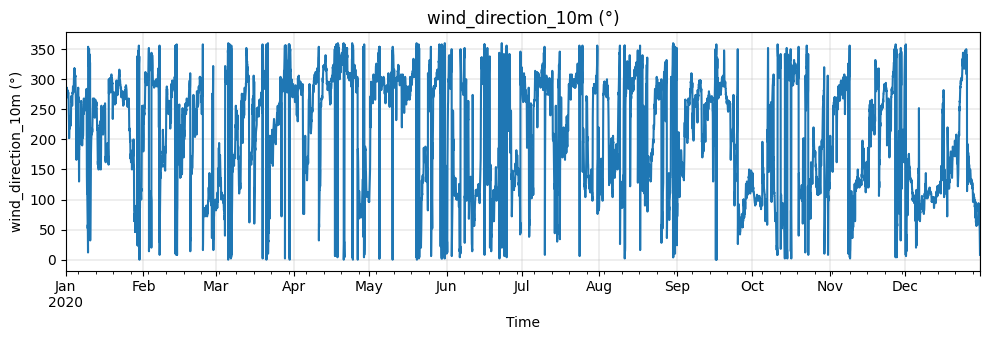

In [2]:
import matplotlib.pyplot as plt

# make 'time' the index for easier time-series plotting
df_ts = df.set_index("time").sort_index()

numeric_cols = df_ts.select_dtypes(include="number").columns.tolist()
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    plt.figure(figsize=(10, 3.5))
    df_ts[col].plot()
    plt.title(col)
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()


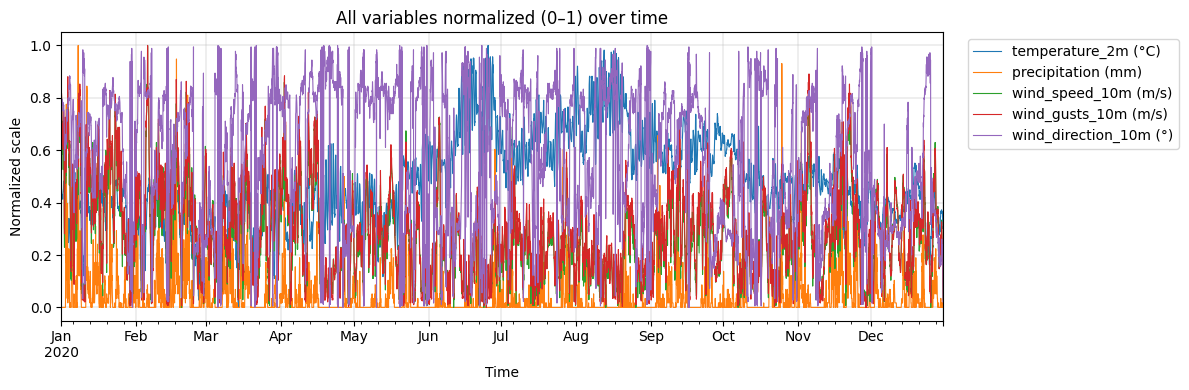

In [ ]:
import matplotlib.pyplot as plt

# time index (if not already)
df_ts = df.set_index("time").sort_index()

# pick numeric columns
num_cols = df_ts.select_dtypes(include="number").columns

# normalize each to 0–1 so they’re comparable on one axis
norm = (df_ts[num_cols] - df_ts[num_cols].min()) / (df_ts[num_cols].max() - df_ts[num_cols].min())

plt.figure(figsize=(12, 4))
norm.plot(ax=plt.gca(), linewidth=0.8)
plt.title("All variables normalized (0–1) over time")
plt.xlabel("Time")
plt.ylabel("Normalized scale")
plt.grid(True, linewidth=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Note: Wind direction is circular (0–360°), so its normalized line is okay for rough comparison,
# but interpretation should be cautious (360° ≈ 0°).
